In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
import copy
import time
from matplotlib import pyplot as plt
import numpy as np

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        return transforms.functional.resize(image, self.output_size)

def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
dataset = datasets.ImageFolder(root='./markup/test/', transform=transforms.Compose([Rescale((28, 18)), transforms.ToTensor()]))

In [9]:
train_cnt = int(len(dataset) * 0.9)
val_cnt = len(dataset) - train_cnt

print('Train samples count = ', train_cnt)
print('Validation samples count = ', val_cnt)

train_set, val_set = torch.utils.data.random_split(dataset, [train_cnt, val_cnt])

train_loader = DataLoader(train_set, batch_size=10, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=10, shuffle=True, num_workers=4)

Train samples count =  93
Validation samples count =  11


In [10]:
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': train_cnt, 'val': val_cnt}

In [29]:
model = resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 27)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.99, nesterov=True)

cuda:0


In [30]:
model_ft = train_model(model, criterion, optimizer_ft, num_epochs=100)

Epoch 0/99
----------
train Loss: 3.5748 Acc: 0.0323
val Loss: 3.3219 Acc: 0.0000

Epoch 1/99
----------
train Loss: 3.3727 Acc: 0.0645
val Loss: 3.4100 Acc: 0.0000

Epoch 2/99
----------
train Loss: 3.3331 Acc: 0.0645
val Loss: 4.4562 Acc: 0.0000

Epoch 3/99
----------
train Loss: 3.2510 Acc: 0.0860
val Loss: 5.3510 Acc: 0.0000

Epoch 4/99
----------
train Loss: 3.0814 Acc: 0.1505
val Loss: 5.8330 Acc: 0.0000

Epoch 5/99
----------
train Loss: 2.7958 Acc: 0.2366
val Loss: 5.8329 Acc: 0.0000

Epoch 6/99
----------
train Loss: 2.6102 Acc: 0.3118
val Loss: 5.1575 Acc: 0.0000

Epoch 7/99
----------
train Loss: 2.3507 Acc: 0.4086
val Loss: 4.5811 Acc: 0.0000

Epoch 8/99
----------
train Loss: 2.0923 Acc: 0.5161
val Loss: 4.1648 Acc: 0.0000

Epoch 9/99
----------
train Loss: 1.8937 Acc: 0.5699
val Loss: 3.7845 Acc: 0.0000

Epoch 10/99
----------
train Loss: 1.7616 Acc: 0.5591
val Loss: 3.1438 Acc: 0.1818

Epoch 11/99
----------
train Loss: 1.6717 Acc: 0.6022
val Loss: 2.7005 Acc: 0.3636

Ep

In [39]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q',
               'R', 'S', 'T', 'trash', 'U', 'V', 'W', 'X', 'Y', 'Z']
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

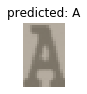

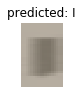

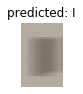

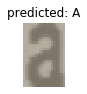

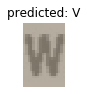

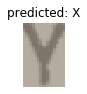

In [40]:
visualize_model(model_ft)